In [1]:
import numpy as np
import pandas as pd

from datetime import date

In [2]:
patterns = {
    'close': 'Fechamento\r\najust p/ prov\r\nEm moeda orig\r\n',
    'negotiable': 'Negociabilidade\n1 meses\nEm moeda orig\n'
}

In [3]:
def clean_dataframe(df, pattern):
    df.columns = df.columns.str.replace(pattern, '')

    dates = pd.to_datetime(df['Data'], dayfirst=True)

    # Detach dates
    tickers = [col for col in df.columns if col != 'Data']
    df = df[tickers]

    # comma_to_dot = lambda x: x.replace('.', '').replace(',', '.')
    # df = df.applymap(comma_to_dot)
    df = df.replace('-', np.nan)
    df = df.apply(pd.to_numeric)

    # Reattach dates
    df['Data'] = dates
    
    # Reorder columns so that dates show up first
    cols = ['Data'] + list(df.columns.drop('Data'))
    df = df[cols]
    
    # Drop weekends and holidays
    df = df.dropna(axis=0, how='all', subset=tickers)
    
    return df

In [4]:
path = './../data/close.csv'
close = pd.read_csv(path, delimiter=',')
close = clean_dataframe(close, patterns['close'])

close.tail()

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9610,2022-11-03,47.88,12.96,NaN,NaN,NaN,NaN,NaN,21.51,NaN,...,NaN,NaN,NaN,NaN,16.07,NaN,NaN,NaN,7.30,NaN
9611,2022-11-04,51.31,13.52,NaN,NaN,NaN,NaN,NaN,21.81,NaN,...,NaN,NaN,NaN,NaN,16.35,NaN,NaN,NaN,7.42,NaN
9612,2022-11-07,48.76,12.74,NaN,NaN,NaN,NaN,NaN,21.05,NaN,...,NaN,NaN,NaN,NaN,14.61,NaN,NaN,NaN,7.00,NaN
9613,2022-11-08,47.00,12.13,NaN,NaN,NaN,NaN,NaN,21.50,NaN,...,NaN,NaN,NaN,NaN,13.98,NaN,NaN,NaN,7.10,NaN
9614,2022-11-09,46.21,12.00,NaN,NaN,NaN,NaN,NaN,21.09,NaN,...,NaN,NaN,NaN,NaN,13.72,NaN,NaN,NaN,7.30,NaN


In [5]:
path = './../data/in.csv'
negotiable = pd.read_csv(path, delimiter=',')
negotiable = clean_dataframe(negotiable, patterns['negotiable'])

negotiable.tail()

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9610,2022-11-03,0.65,0.1,NaN,NaN,NaN,NaN,NaN,0.10,NaN,...,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,0.06,NaN
9611,2022-11-04,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.10,NaN,...,NaN,NaN,NaN,NaN,0.45,NaN,NaN,NaN,0.06,NaN
9612,2022-11-07,0.60,0.1,NaN,NaN,NaN,NaN,NaN,0.11,NaN,...,NaN,NaN,NaN,NaN,0.47,NaN,NaN,NaN,0.06,NaN
9613,2022-11-08,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.11,NaN,...,NaN,NaN,NaN,NaN,0.47,NaN,NaN,NaN,0.06,NaN
9614,2022-11-09,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.10,NaN,...,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,0.06,NaN


### Índice Brasil 100 (IBrX100 B3)

In [6]:
def get_IBRX_assets(_date):
    s = negotiable.set_index('Data').loc[:_date].iloc[-1]
    s = s.sort_values(ascending=False)
    return s.index[:100]

In [7]:
get_IBRX_assets(date(2022, 11, 10))

Index(['PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'BBAS3', 'MGLU3', 'B3SA3', 'PETR3',
       'ELET3', 'AMER3', 'RENT3', 'ABEV3', 'HAPV3', 'PRIO3', 'LREN3', 'ASAI3',
       'CSAN3', 'BPAC11', 'WEGE3', 'RAIL3', 'SUZB3', 'GGBR4', 'ITSA4', 'NTCO3',
       'VIIA3', 'SBSP3', 'BBSE3', 'MRVE3', 'RADL3', 'JBSS3', 'EQTL3', 'RDOR3',
       'HYPE3', 'CIEL3', 'BRKM5', 'CMIG4', 'CSNA3', 'CYRE3', 'TOTS3', 'VBBR3',
       'BRFS3', 'RRRP3', 'ENEV3', 'COGN3', 'ELET6', 'TIMS3', 'KLBN11', 'AZUL4',
       'PETZ3', 'CCRO3', 'BBDC3', 'USIM5', 'BRAP4', 'CPLE6', 'MULT3', 'YDUQ3',
       'VIVT3', 'UGPA3', 'GOAU4', 'CRFB3', 'MRFG3', 'BRML3', 'GOLL4', 'BEEF3',
       'LWSA3', 'SOMA3', 'SULA11', 'ENGI11', 'SANB11', 'ENBR3', 'ALPA4',
       'EMBR3', 'TAEE11', 'CVCB3', 'ARZZ3', 'RAIZ4', 'GMAT3', 'IGTI11',
       'CPFE3', 'RECV3', 'EGIE3', 'FLRY3', 'IRBR3', 'PCAR3', 'SLCE3', 'AURE3',
       'SMTO3', 'DXCO3', 'PSSA3', 'CBAV3', 'VAMO3', 'MDIA3', 'CASH3', 'MOVI3',
       'TRPL4', 'INTB3', 'CMIN3', 'DIRR3', 'OIBR3', 'QUAL3'],
 

### Momentum

In [8]:
def list_returns(df, today, lookback=1):
    """
    Takes in a DataFrame with time series and lists 
    compounded returns of a dataframe of assets.
    """
    start = today - pd.DateOffset(months=lookback)
    _filter = df.set_index('Data').loc[start:today, :]
    return _filter.pct_change().add(1).cumprod().iloc[-1]

def get_momentum_assets(df, today, lookback=1, assets=10):
    returns = list_returns(df, today, lookback=lookback)
    returns = returns.sort_values(ascending=False).dropna()
    
    if len(returns) < assets:
        return returns.index
    return returns.index[:assets]

In [9]:
def get_ibrx_momentum_asets(_date, lookback=1, assets=10):
    ibrx = get_IBRX_assets(_date)
    cols = list(ibrx) + ['Data']

    ibrx = close.loc[:, cols]
    
    ibrx_assets = get_momentum_assets(ibrx, _date, lookback=lookback, assets=assets)

    return list(ibrx_assets)

### Backtest

In [10]:
start_date = date(2017, 1, 1)
end_date   = date(2022, 1, 1)

def run_backtest(lookback, assets, start=start_date, end=end_date, rebalance=1):
    today = pd.Timestamp(start)

    portfolio = pd.DataFrame()
    while today.date() <= end:
        portfolio_rebalance = today + pd.DateOffset(months=rebalance)

        # Get 100 most liquid assets today
        tickers = get_ibrx_momentum_asets(today, lookback=lookback, assets=assets)

        # offset: How many days has it been since the last trading day?
        # why? because if it is January 4th, we buy assets for January 3rd closing prices
        day = close.set_index('Data').loc[:today].reset_index().iloc[-1]['Data']
        offset = today - day

        wf = close.set_index('Data').loc[today - offset:portfolio_rebalance - pd.DateOffset(days=1), tickers]
        wf = wf.pct_change()

        portfolio = pd.concat([portfolio, wf.iloc[1:].mean(axis=1)])

        today = portfolio_rebalance
        
    return portfolio.add(1).cumprod()

In [11]:
portfolio = run_backtest(7, 5)
portfolio.head()

,0
2017-01-02,1.001003
2017-01-03,1.014314
2017-01-04,1.028716
2017-01-05,1.049316
2017-01-06,1.050635


### Use QuantStats to extract portfolio analysis

                           Strategy
-------------------------  ----------
Start Period               2017-01-02
End Period                 2022-01-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          318.49%
CAGR﹪                     32.53%

Sharpe                     0.94
Prob. Sharpe Ratio         97.63%
Smart Sharpe               0.88
Sortino                    1.29
Smart Sortino              1.21
Sortino/√2                 0.91
Smart Sortino/√2           0.86
Omega                      1.19

Max Drawdown               -62.41%
Longest DD Days            354
Volatility (ann.)          40.29%
Calmar                     0.52
Skew                       -1.3
Kurtosis                   13.65

Expected Daily %           0.12%
Expected Monthly %         2.37%
Expected Yearly %          26.94%
Kelly Criterion            8.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.02%
Expected Shortfall (cVaR)  -4.02%

Max Consecutive Wins   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-23,2020-03-18,2021-01-11,354,-62.410034,-56.444425
2,2021-07-27,2021-11-30,2022-01-31,188,-38.828233,-36.728048
3,2017-02-21,2017-04-13,2017-08-31,191,-28.840184,-28.443572
4,2017-10-11,2017-11-10,2018-01-02,83,-19.389815,-18.670754
5,2019-08-14,2019-08-26,2019-12-13,121,-17.907174,-14.126944


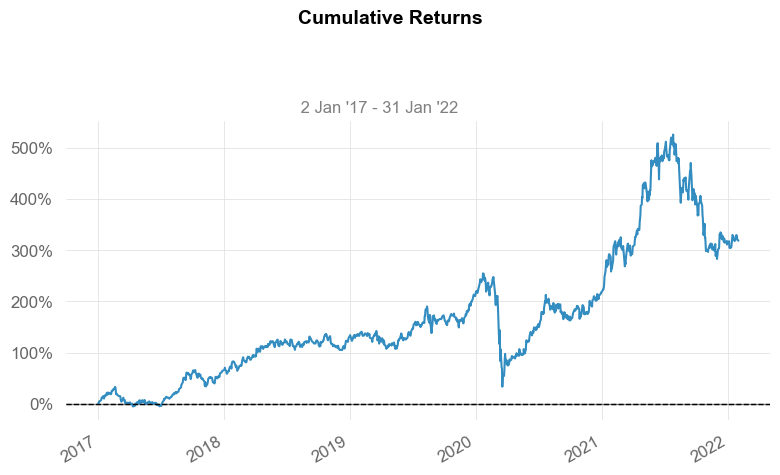

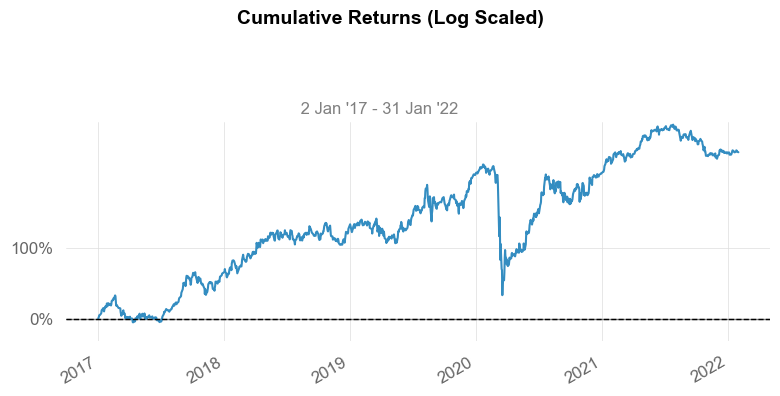

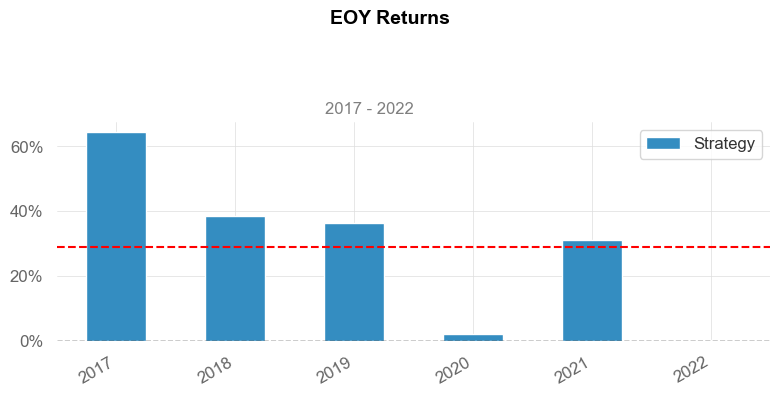

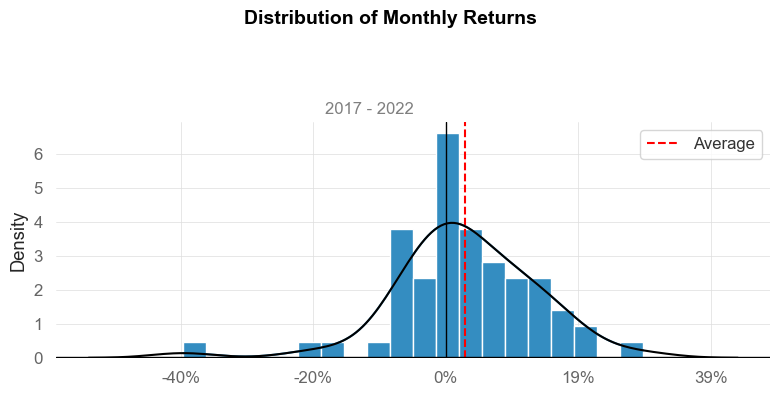

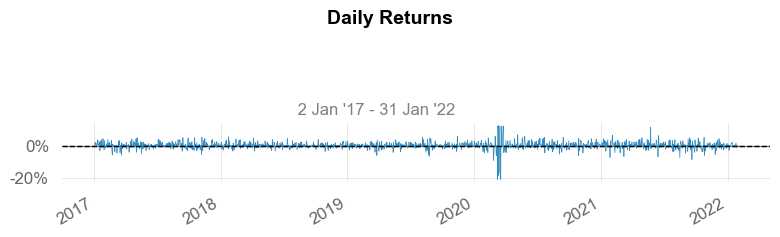

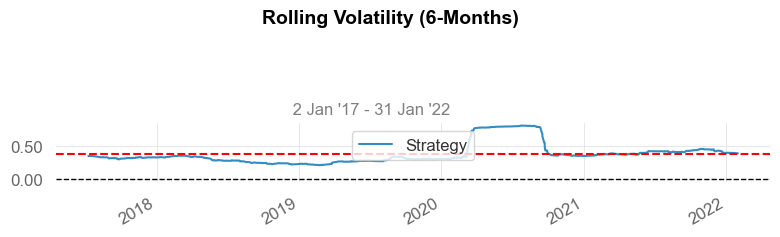

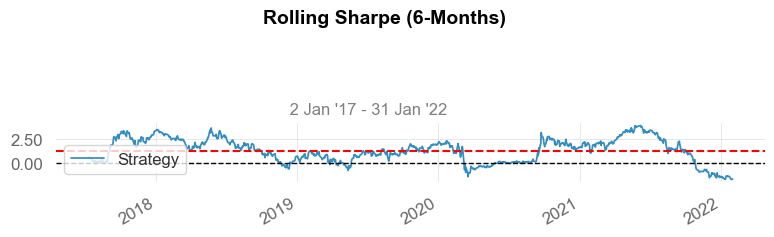

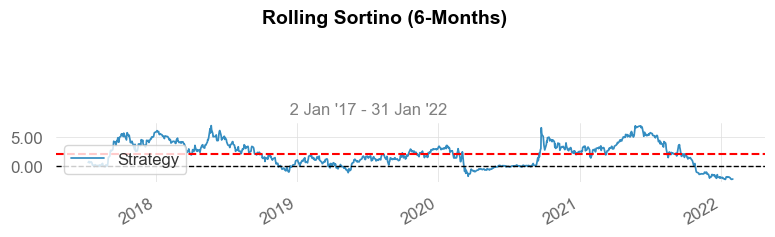

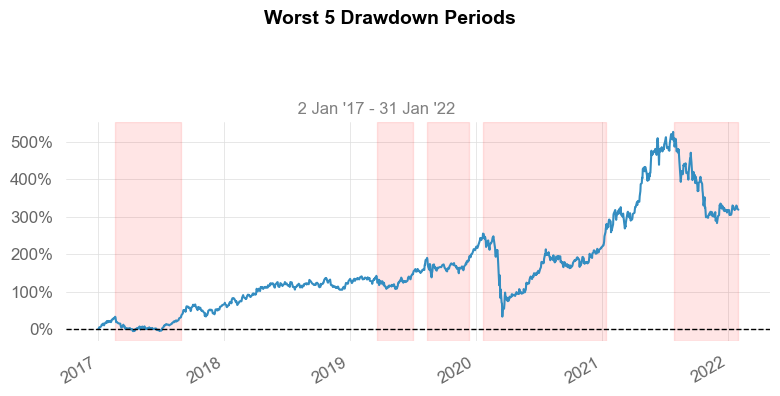

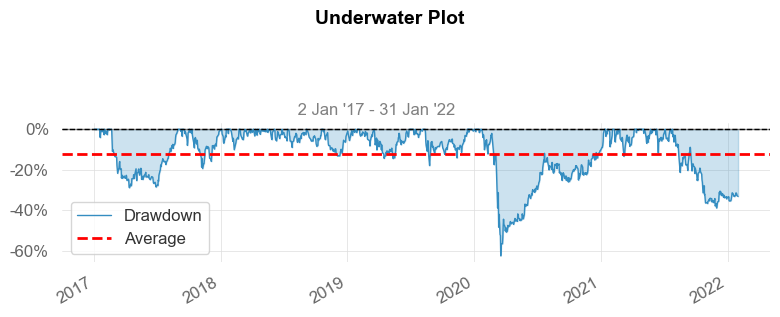

/Users/pedro/Developer/quant-modeling/venv/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


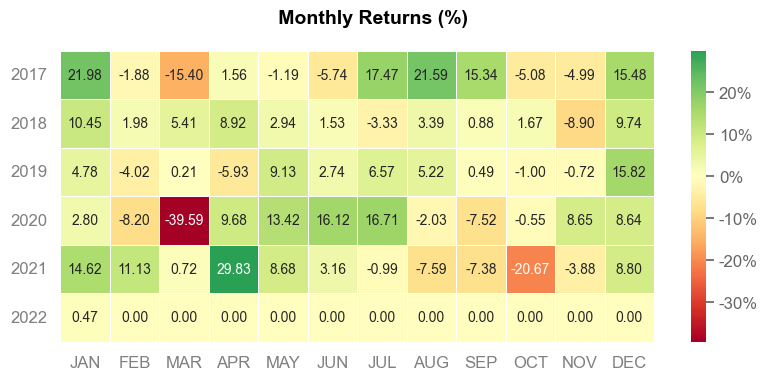

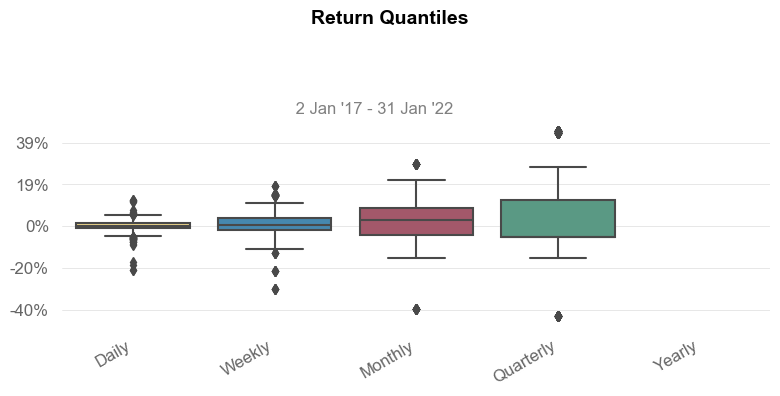

In [12]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

portfolio = run_backtest(7, 5)
qs.reports.full(portfolio[0])